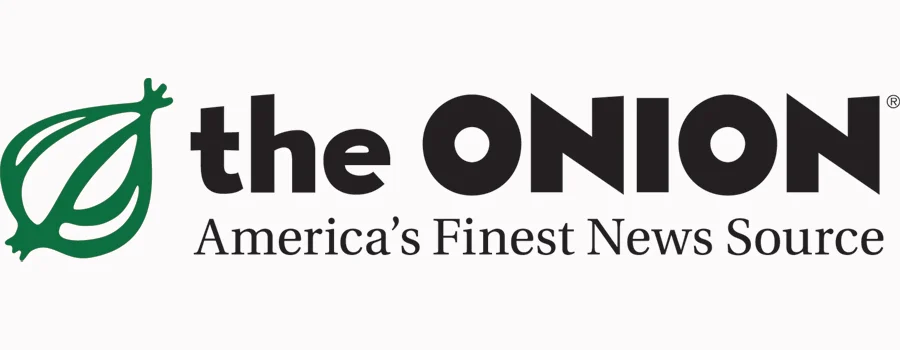

***The Onion*** is an American satirical digital media company and newspaper organization that publishes articles on international, national, and local news.

*The Onion*'s articles cover current events, both real and fictional, parodying the tone and format of traditional news organizations with stories, editorials, and man-on-the-street interviews using a traditional news website layout and an editorial voice modeled after that of the Associated Press. The publication's humor often depends on presenting mundane, everyday events as newsworthy, surreal, or alarming, such as "Rotation of Earth Throws Entire North American Continent into Darkness". In 1999, comedian Bob Odenkirk praised the publication as "the best comedy writing in the country".

Knowing what Onion is, we can continue to analyze if there is any difference between Onion news and real news? And what is the difference?

## Load libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
import re

In [ ]:
df = pd.read_csv('../input/onion-or-not/OnionOrNot.csv')
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
df['label'].value_counts(normalize=True)*100

In [ ]:
df.duplicated().sum()

## Feature Engineering

Count how many words in each row

In [ ]:
df['WordCount'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.head()

Count characters

In [ ]:
df['CharCount'] = df['text'].str.len()
df.head()

Count how many stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop = stopwords.words('english')

In [ ]:
df['Stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df.head()

Removing special characters, all words to lowercase, and remove whitespace

In [ ]:
df['text'] = df['text'].map(lambda x: re.sub(r'[^a-zA-Z\s]', '',x,re.I|re.A))
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()
df.head()

In [ ]:
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head()

Remove Stopwords

In [ ]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.head()

Lemmatization

In [ ]:
import en_core_web_sm

sp = en_core_web_sm.load()

def lemma(input_str):
    s = sp(input_str)
    
    input_list = []
    for word in s:
        w = word.lemma_
        input_list.append(w)
        
    output = ' '.join(input_list)
    return output

df['text'] = df['text'].apply(lambda x: lemma(x))


df.head()

## WordCloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
onion = df[df['label'] == 1].text
news = df[df['label'] == 0].text

In [ ]:
# WordCloud for Onion
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 ).generate(" ".join(onion))
plt.imshow(wc , interpolation = 'nearest')

In [ ]:
# WordCloud for News
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 ).generate(" ".join(news))
plt.imshow(wc , interpolation = 'nearest')

## Data Visualizations

Pair Plot

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(df, hue="label")
plt.show()

For some reson, there was an error runing above codes in Kaggle Kernel, I did not have any issues running on Google Colab. Below is the plot that suppose to generate

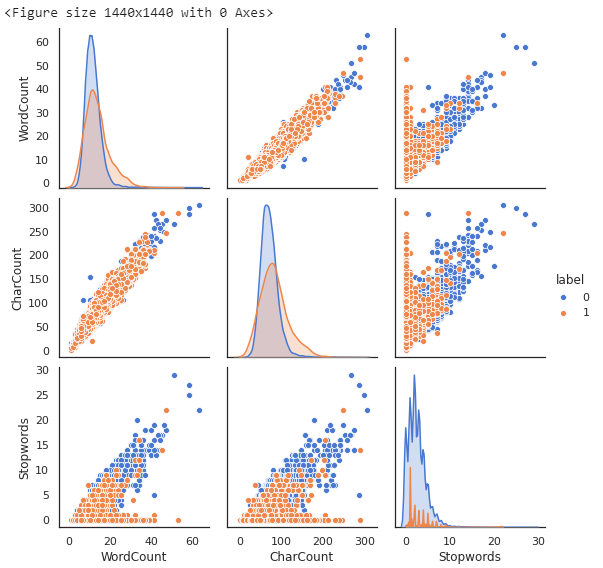

In [ ]:
grouped = df.groupby('label').mean().reset_index()
grouped

In [ ]:
df.groupby('label').mean().plot.bar(subplots=True, figsize=(10,10), grid=True)

Looks like Onion titles tend to have a longer title using slightly more words and characters, but less stopwords.

## Preparing to build the models

Using the top 300 frequent word to calculate TF-IDF matrix

In [ ]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[0:300]
freq = list(freq.index)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=len(freq), lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
df_vect = tfidf.fit_transform(df['text'])
text_df = pd.DataFrame(df_vect.toarray(), columns=tfidf.get_feature_names())

text_df.head()

Concatenate the TF-IDF matrix with WordCount, CharCount and Stopwords

In [ ]:
text_df['WordCount'] = df['WordCount']
text_df['CharCount'] = df['CharCount']
text_df['Stopwords'] = df['Stopwords']
text_df.info()

Assign the features and target before split into training/testing set

In [ ]:
X = text_df
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
    
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

## Models

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_lr_pred))
print(confusion_matrix(y_test, y_lr_pred))
print(classification_report(y_test,y_lr_pred))

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_rfc_pred))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test,y_rfc_pred))

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_dtc_pred = dtc.predict(X_test)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_dtc_pred))
print(confusion_matrix(y_test, y_dtc_pred))
print(classification_report(y_test,y_dtc_pred))

Naive-Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_mnb_pred = mnb.predict(X_test)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_mnb_pred))
print(confusion_matrix(y_test, y_mnb_pred))
print(classification_report(y_test,y_mnb_pred))

Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_ada_pred = ada.predict(X_test)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_ada_pred))
print(confusion_matrix(y_test, y_ada_pred))
print(classification_report(y_test,y_ada_pred))

XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_std, y_train)
y_xgb_pred = xgb.predict(X_test_std)

In [ ]:
print('Accuracy: %.4f' % accuracy_score(y_test, y_xgb_pred))
print(confusion_matrix(y_test, y_xgb_pred))
print(classification_report(y_test,y_xgb_pred))

## Final thought:

Ada Boosting yields the best performance in predicting Onion or Not task. It yields an accuracy of 90.68%, a percision of 83%, and a recall of 95%.

I struggle with neural network with Kera. The highest accuracy I could get from a DNN model is around 85%, and that is even lower than the Logistic Regression.

That being said, DNN models are great in many situations, but they are not the solutions to all dataset. We need to try different algorithms to find the best fit.

All feedbacks are welcome and I look forward to hear back from you.

Thank you https://www.kaggle.com/madz2000/wordcloud-other-classifiers for the WordCloud